In [20]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score

# Ensure TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("Using GPU!")
else:
    print("Using CPU. Check your CUDA installation if you expect to use a GPU.")

# Set the paths to the train and test directories
train_dir = "./AiOrNot/train"
test_dir = "./AiOrNot/test"

# Set up the model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

batch_size = 32

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Perform data augmentation and split for validation
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)

# Load the training data
train_generator = datagen.flow_from_directory(train_dir, target_size=(32, 32),
                                              batch_size=batch_size, class_mode='binary', subset='training')

# Load the validation data
val_generator = datagen.flow_from_directory(train_dir, target_size=(32, 32),
                                            batch_size=batch_size, class_mode='binary', subset='validation')

# Train the model on GPU if available, including validation data
with tf.device('/GPU:0'):
    history = model.fit(train_generator, steps_per_epoch=train_generator.n // batch_size, epochs=15,
                        validation_data=val_generator, validation_steps=val_generator.n // batch_size)

# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(32, 32),
                                                  batch_size=batch_size, class_mode='binary', shuffle=False)

# Make predictions on the test data
predictions = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predictions]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels, predictions)
print("\nMean Average Precision (mAP):", mAP)


Num GPUs Available:  1
Using GPU!
Found 5532 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
Epoch 1/15
172/172 [==============================] - 146s 847ms/step - loss: 0.3800 - accuracy: 0.8284 - val_loss: 0.2723 - val_accuracy: 0.8953
Epoch 2/15
172/172 [==============================] - 154s 894ms/step - loss: 0.3082 - accuracy: 0.8696 - val_loss: 0.2505 - val_accuracy: 0.8997
Epoch 3/15
172/172 [==============================] - 149s 864ms/step - loss: 0.2802 - accuracy: 0.8855 - val_loss: 0.2527 - val_accuracy: 0.8961
Epoch 4/15
172/172 [==============================] - 144s 838ms/step - loss: 0.2659 - accuracy: 0.8880 - val_loss: 0.2406 - val_accuracy: 0.9048
Epoch 5/15
172/172 [==============================] - 134s 779ms/step - loss: 0.2493 - accuracy: 0.8951 - val_loss: 0.2285 - val_accuracy: 0.9121
Epoch 6/15
172/172 [==============================] - 155s 900ms/step - loss: 0.2523 - accuracy: 0.8967 - val_loss: 0.2338 - val_accuracy: 0.9055
Epoch 

Found 288 images belonging to 2 classes.
9/9 [==============================] - 5s 452ms/step

Accuracy: 0.9131944444444444

Confusion Matrix:
[[ 93   7]
 [ 18 170]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.84      0.93      0.88       100
        REAL       0.96      0.90      0.93       188

    accuracy                           0.91       288
   macro avg       0.90      0.92      0.91       288
weighted avg       0.92      0.91      0.91       288


Mean Average Precision (mAP): 0.9839891171397898


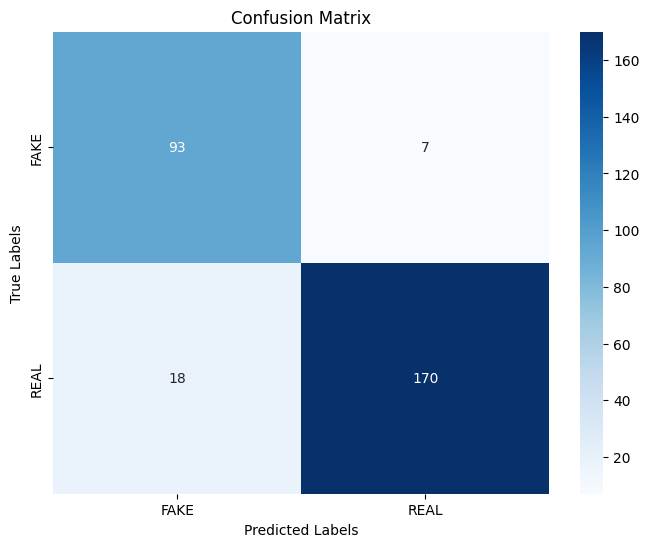

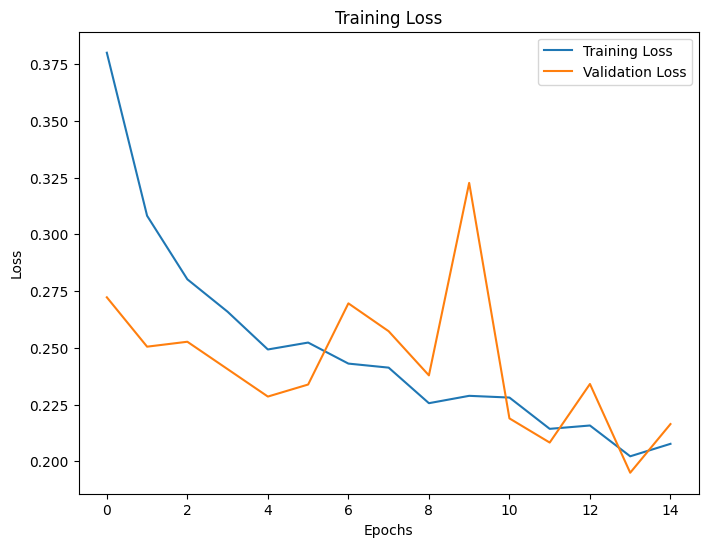

In [21]:
model.save('vgg16_val.h5')

import seaborn as sns

# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(32, 32),
                                                  batch_size=batch_size, class_mode='binary', shuffle=False)

# Make predictions on the test data
predictions = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predictions]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels, predictions)
print("\nMean Average Precision (mAP):", mAP)

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Loss plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [12]:
from tensorflow.keras.models import load_model

model = load_model('vgg16_val.h5')  # Make sure to provide the correct path to your model file
from tensorflow.keras.preprocessing import image
import numpy as np

# Replace with the path to your new image
image_path = "./fake_car2.png"

# Load the image
img = image.load_img(image_path, target_size=(32, 32))  # Resize it to 32x32 to match the model's expected input

# Convert the image to a numpy array and scale the pixel values
img_array = image.img_to_array(img) / 255.0

# Add a batch dimension
img_array = np.expand_dims(img_array, axis=0)
predictions = model.predict(img_array)
predicted_class = (predictions > 0.5).astype("int32")


1/1 [==============================] - 0s 136ms/step


In [13]:
predicted_class

array([[1]])

In [14]:
# If you have more than two classes, replace this with the actual class names
class_names = ['Fake', 'Real']  # Replace with your actual class names

# Print the prediction
print(f"This image is a: {class_names[predicted_class[0][0]]} ")


This image is a: Real 


In [24]:
print(train_generator.class_indices)


{'FAKE': 0, 'REAL': 1}


In [10]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
from tensorflow.keras.optimizers import Adam


# Ensure TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("Using GPU!")
else:
    print("Using CPU. Check your CUDA installation if you expect to use a GPU.")

# Set the paths to the train and test directories
train_dir = "./AiOrNot/train"
test_dir = "./AiOrNot/test"

# Set up the model with ResNet50 base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Perform data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(32, 32), batch_size=32, class_mode='binary')

# Train the model on GPU if available
with tf.device('/GPU:0'):
    history = model.fit(train_generator, steps_per_epoch=train_generator.n // 32, epochs=15)

# Load and preprocess test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(32, 32), batch_size=32, class_mode='binary', shuffle=False)

# Evaluate the model
predictions = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predictions]

# Calculate and print accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)
print("\nAccuracy:", accuracy)

# Confusion matrix and classification report
cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Mean Average Precision
mAP = average_precision_score(test_generator.labels, predictions)
print("\nMean Average Precision (mAP):", mAP)


Num GPUs Available:  1
Using GPU!
Found 6913 images belonging to 2 classes.
Epoch 1/15
216/216 [==============================] - 138s 620ms/step - loss: 0.7184 - accuracy: 0.6053
Epoch 2/15
216/216 [==============================] - 129s 599ms/step - loss: 0.5750 - accuracy: 0.7054
Epoch 3/15
216/216 [==============================] - 128s 593ms/step - loss: 0.5585 - accuracy: 0.7239
Epoch 4/15
216/216 [==============================] - 129s 595ms/step - loss: 0.5451 - accuracy: 0.7365
Epoch 5/15
216/216 [==============================] - 130s 602ms/step - loss: 0.5296 - accuracy: 0.7493
Epoch 6/15
216/216 [==============================] - 129s 596ms/step - loss: 0.5257 - accuracy: 0.7484
Epoch 7/15
216/216 [==============================] - 129s 598ms/step - loss: 0.5175 - accuracy: 0.7545
Epoch 8/15
216/216 [==============================] - 129s 596ms/step - loss: 0.5123 - accuracy: 0.7656
Epoch 9/15
216/216 [==============================] - 128s 595ms/step - loss: 0.5071 - accur

In [11]:
model.save('resnet50.h5')


Found 288 images belonging to 2 classes.
9/9 [==============================] - 5s 458ms/step

Accuracy: 0.6631944444444444

Confusion Matrix:
[[96  4]
 [93 95]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.51      0.96      0.66       100
        REAL       0.96      0.51      0.66       188

    accuracy                           0.66       288
   macro avg       0.73      0.73      0.66       288
weighted avg       0.80      0.66      0.66       288


Mean Average Precision (mAP): 0.9231493795984032


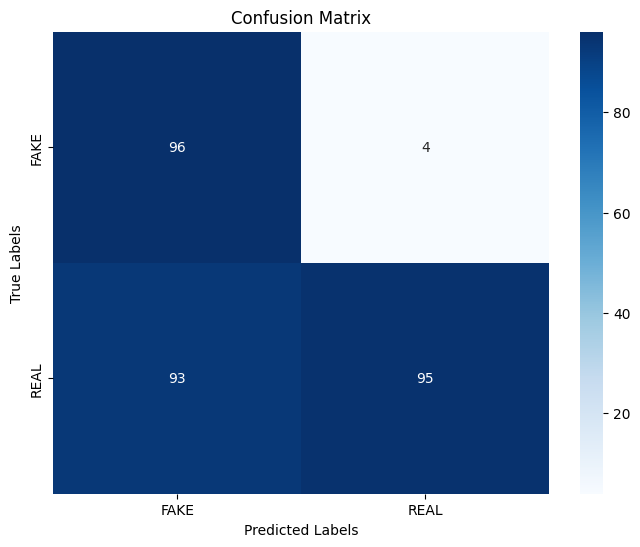

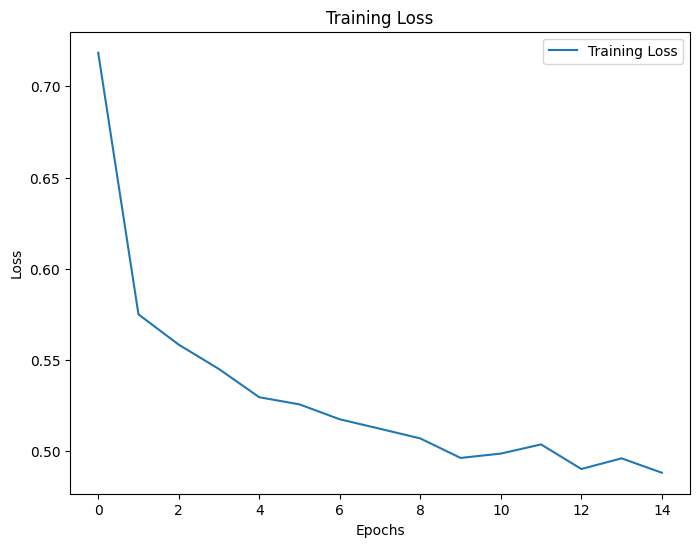

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(32, 32),
                                                  batch_size=32, class_mode='binary', shuffle=False)

# Make predictions on the test data
predictions = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predictions]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels, predictions)
print("\nMean Average Precision (mAP):", mAP)

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Loss plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [14]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
from tensorflow.keras.optimizers import Adam

# Ensure TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("Using GPU!")
else:
    print("Using CPU. Check your CUDA installation if you expect to use a GPU.")

# Set the paths to the train and test directories
train_dir = "./AiOrNot/train"
test_dir = "./AiOrNot/test"

# Set up the model with InceptionV3 base
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation for training data and split for validation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(75, 75), batch_size=32, class_mode='binary', subset='training')
val_generator = train_datagen.flow_from_directory(train_dir, target_size=(75, 75), batch_size=32, class_mode='binary', subset='validation')

# Train the model on GPU if available, including validation data
with tf.device('/GPU:0'):
    history = model.fit(train_generator, 
                        steps_per_epoch=train_generator.n // 32, 
                        epochs=15, 
                        validation_data=val_generator, 
                        validation_steps=val_generator.n // 32)

# Load and preprocess test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(75, 75), batch_size=32, class_mode='binary', shuffle=False)

# Evaluate the model
predictions = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predictions]

# Calculate and print accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)
print("\nAccuracy:", accuracy)

# Confusion matrix and classification report
cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Mean Average Precision
mAP = average_precision_score(test_generator.labels, predictions)
print("\nMean Average Precision (mAP):", mAP)


Num GPUs Available:  1
Using GPU!
Found 5532 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
Epoch 1/15
172/172 [==============================] - 154s 869ms/step - loss: 0.5801 - accuracy: 0.7124 - val_loss: 0.3409 - val_accuracy: 0.8743
Epoch 2/15
172/172 [==============================] - 146s 849ms/step - loss: 0.4060 - accuracy: 0.8231 - val_loss: 0.3186 - val_accuracy: 0.8612
Epoch 3/15
172/172 [==============================] - 146s 849ms/step - loss: 0.3666 - accuracy: 0.8447 - val_loss: 0.2774 - val_accuracy: 0.8917
Epoch 4/15
172/172 [==============================] - 148s 863ms/step - loss: 0.3339 - accuracy: 0.8624 - val_loss: 0.2661 - val_accuracy: 0.8990
Epoch 5/15
172/172 [==============================] - 148s 861ms/step - loss: 0.3207 - accuracy: 0.8700 - val_loss: 0.2721 - val_accuracy: 0.8924
Epoch 6/15
172/172 [==============================] - 144s 841ms/step - loss: 0.3040 - accuracy: 0.8758 - val_loss: 0.2523 - val_accuracy: 0.9070
Epoch 

In [15]:
model.save('inceptionv3_.h5')


Found 288 images belonging to 2 classes.


9/9 [==============================] - 4s 445ms/step

Accuracy: 0.9027777777777778

Confusion Matrix:
[[ 96   4]
 [ 24 164]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.80      0.96      0.87       100
        REAL       0.98      0.87      0.92       188

    accuracy                           0.90       288
   macro avg       0.89      0.92      0.90       288
weighted avg       0.92      0.90      0.90       288


Mean Average Precision (mAP): 0.9901718102644613


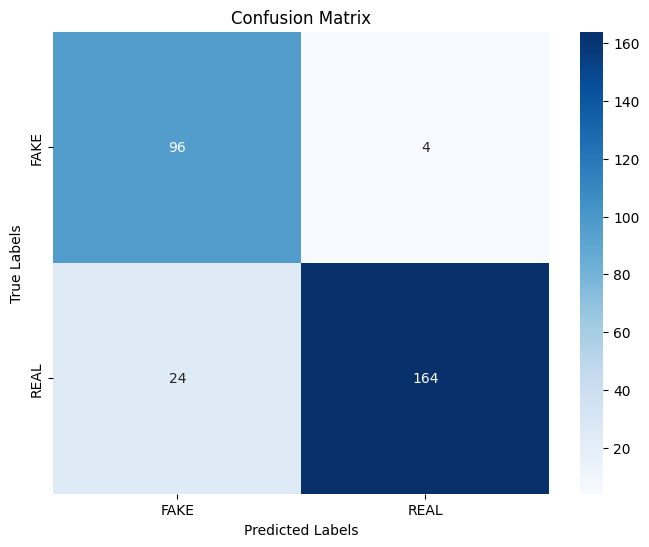

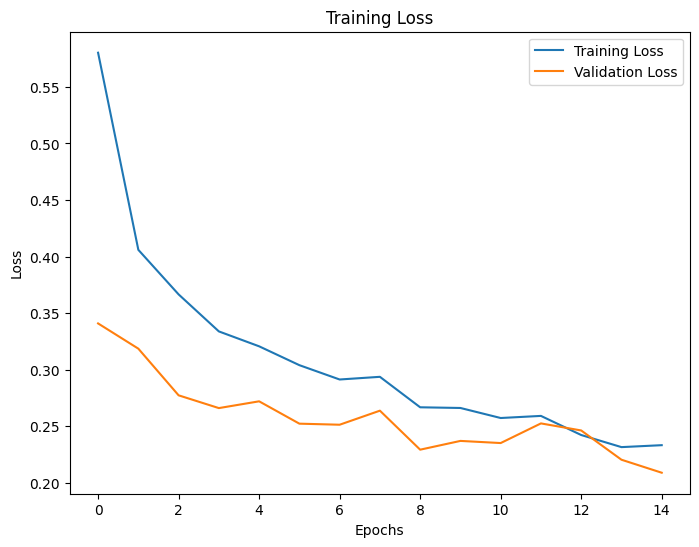

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(75, 75),
                                                  batch_size=32, class_mode='binary', shuffle=False)

# Make predictions on the test data
predictions = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predictions]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels, predictions)
print("\nMean Average Precision (mAP):", mAP)

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Loss plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [22]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np  
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score

# Ensure TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("Using GPU!")
else:
    print("Using CPU. Check your CUDA installation if you expect to use a GPU.")

# Set the paths to the train and test directories
train_dir = "./AiOrNot/train"
test_dir = "./AiOrNot/test"

# Set up the model with DenseNet121 base
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

batch_size = 32

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Perform data augmentation and split for validation
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)

# Load the training data
train_generator = datagen.flow_from_directory(train_dir, target_size=(32, 32),
                                              batch_size=batch_size, class_mode='binary', subset='training')

# Load the validation data
val_generator = datagen.flow_from_directory(train_dir, target_size=(32, 32),
                                            batch_size=batch_size, class_mode='binary', subset='validation')

# Train the model on GPU if available, including validation data
with tf.device('/GPU:0'):
    history = model.fit(train_generator, steps_per_epoch=train_generator.n // batch_size, epochs=15,
                        validation_data=val_generator, validation_steps=val_generator.n // batch_size)

# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(32, 32),
                                                  batch_size=batch_size, class_mode='binary', shuffle=False)

# Make predictions on the test data
predictions = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predictions]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels, predictions)
print("\nMean Average Precision (mAP):", mAP)


Num GPUs Available:  1
Using GPU!
29084464/29084464 [==============================] - 26s 1us/step
Found 5532 images belonging to 2 classes.
Found 1381 images belonging to 2 classes.
Epoch 1/15
172/172 [==============================] - 152s 838ms/step - loss: 0.3828 - accuracy: 0.8307 - val_loss: 0.2842 - val_accuracy: 0.8735
Epoch 2/15
172/172 [==============================] - 145s 844ms/step - loss: 0.2988 - accuracy: 0.8718 - val_loss: 0.2342 - val_accuracy: 0.9070
Epoch 3/15
172/172 [==============================] - 152s 885ms/step - loss: 0.2719 - accuracy: 0.8856 - val_loss: 0.2555 - val_accuracy: 0.8844
Epoch 4/15
172/172 [==============================] - 140s 816ms/step - loss: 0.2553 - accuracy: 0.8929 - val_loss: 0.2408 - val_accuracy: 0.8997
Epoch 5/15
172/172 [==============================] - 135s 786ms/step - loss: 0.2398 - accuracy: 0.9005 - val_loss: 0.2277 - val_accuracy: 0.9128
Epoch 6/15
172/172 [==============================] - 135s 786ms/step - loss: 0.2335 -

Found 288 images belonging to 2 classes.
9/9 [==============================] - 4s 430ms/step

Accuracy: 0.9131944444444444

Confusion Matrix:
[[ 91   9]
 [ 16 172]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.85      0.91      0.88       100
        REAL       0.95      0.91      0.93       188

    accuracy                           0.91       288
   macro avg       0.90      0.91      0.91       288
weighted avg       0.92      0.91      0.91       288


Mean Average Precision (mAP): 0.9886220061728221


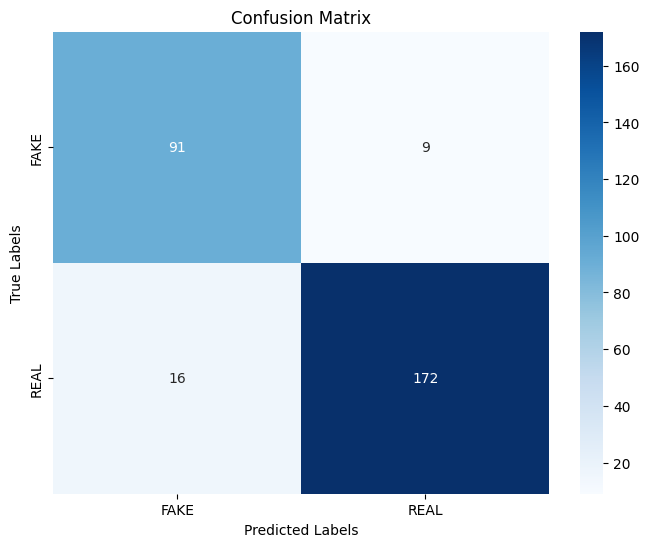

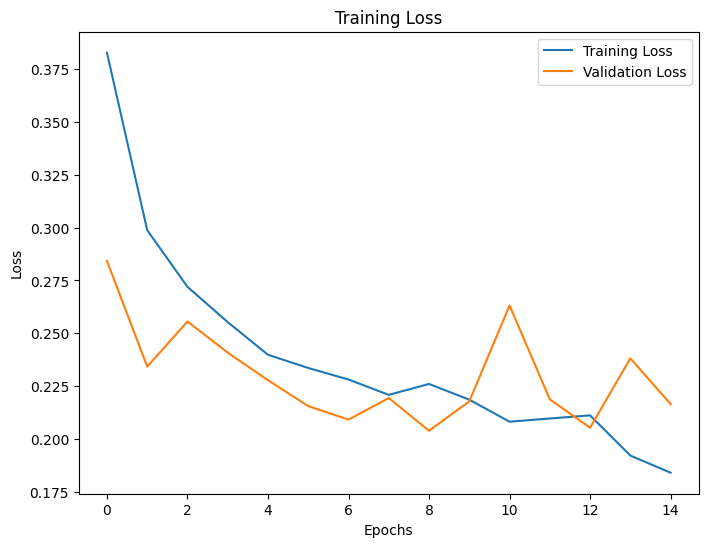

: 

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(32,32),
                                                  batch_size=32, class_mode='binary', shuffle=False)

# Make predictions on the test data
predictions = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predictions]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels, predictions)
print("\nMean Average Precision (mAP):", mAP)

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Loss plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()